In [ ]:

paths = '/scratch/sisodiya.bhoomeendra'

final_data = getPickel("/scratch/sisodiya.bhoomendra/train_data.pkl")

data = final_data.tocsr()

del final_data
import gc; gc.collect()

data_y = data[:,0]
data_y = data_y.astype(dtype=np.int8)
data_x = data[:,1:]
del data
import gc; gc.collect()

dense_data_y = data_y.todense()
del data_y
gc.collect()
k = np.squeeze(np.asarray(dense_data_y.reshape(-1)))

k = k-1

dense_data_x = data_x.todense()
del data_x
gc.collect()

from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(dense_data_x, k,stratify=k,test_size=0.20)

del dense_data_x,dense_data_y
gc.collect()

X_train_n, X_cv, y_train_n, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)
del X_train,y_train
gc.collect()
X_train = X_train_n
y_train = y_train_n

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

# 1

In [1]:
import pickle as pkl
import os
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def getPickel(path):
    file = open(path,'rb')
    obj =  pkl.load(file)
    return obj

def putPickel(var,path):
    file = open(path,'wb')
    pkl.dump(var,file)
    file.close()

# 2

In [2]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss


In [ ]:
alpha=[100,500,1000]
cv_log_error_array=[]
xgb_models = []

for i in alpha:
    print("Going to fit")
    x_cfl=XGBClassifier(n_estimators=i,tree_method='gpu_hist')
    x_cfl.fit(X_train,y_train)
    print("XGB Fitted")
    xgb_models.append(x_cfl)

In [6]:
print("Going to fit")
x_cfl=XGBClassifier(n_estimators=1000,tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
print("XGB Fitted")
xgb_models.append(x_cfl)

Going to fit
XGB Fitted


In [21]:
print("Going to fit")
x_cfl=XGBClassifier(n_estimators=3000,tree_method='gpu_hist')
x_cfl.fit(X_train,y_train)
print("XGB Fitted")
xgb_models.append(x_cfl)

Going to fit
XGB Fitted


In [22]:
len(xgb_models)

4

In [23]:
putPickel(xgb_models,"/scratch/sisodiya.bhoomendra/xgb_models.pkl")

In [9]:
putPickel(X_train,"/scratch/sisodiya.bhoomendra/X_train.pkl")
putPickel(y_train,"/scratch/sisodiya.bhoomendra/y_train.pkl")
putPickel(X_test,"/scratch/sisodiya.bhoomendra/X_test.pkl")
putPickel(y_test,"/scratch/sisodiya.bhoomendra/y_test.pkl")
putPickel(X_cv,"/scratch/sisodiya.bhoomendra/X_cv.pkl")
putPickel(y_cv,"/scratch/sisodiya.bhoomendra/y_cv.pkl")

In [3]:
X_train = getPickel("/scratch/sisodiya.bhoomendra/X_train.pkl")

In [4]:
X_train.shape

(6955, 66307)

In [50]:
X_train_arr

array([[5.52246094e-01, 2.36110000e+04, 1.38700000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 7.96100000e+03],
       [1.26025391e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.41760000e+05],
       [8.09960938e+00, 1.15100000e+04, 5.45300000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.39886400e+06],
       ...,
       [1.60009766e+00, 4.93960000e+04, 5.05500000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.47500000e+04],
       [8.63769531e-01, 8.32700000e+04, 1.13100000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.37700000e+03],
       [8.09960938e+00, 1.15040000e+04, 5.67100000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.39742400e+06]])

In [26]:
X_train_arr = np.array(X_train)

In [27]:
sums = np.sum(X_train_arr,axis=0)

31232.238090515137

# 3

In [3]:
xgb_models = getPickel("/scratch/sisodiya.bhoomendra/xgb_models.pkl")
X_train = getPickel("/scratch/sisodiya.bhoomendra/X_train.pkl")
y_train = getPickel("/scratch/sisodiya.bhoomendra/y_train.pkl")
X_cv = getPickel("/scratch/sisodiya.bhoomendra/X_cv.pkl")
y_cv = getPickel("/scratch/sisodiya.bhoomendra/y_cv.pkl")

In [5]:
len(xgb_models)

4

In [6]:
sig_clf = CalibratedClassifierCV(xgb_models[-1], method="sigmoid")
sig_clf.fit(X_train, y_train)
print("Calibrated")

Calibrated


NameError: name 'calibration_models' is not defined

# 5

In [8]:
calibration_models = getPickel("/scratch/sisodiya.bhoomendra/calibration_models.pkl")

In [10]:
calibration_models.append(sig_clf)

In [11]:
len(xgb_models)

4

In [12]:
cv_log_error_array = []

for x_cfl,sig_clf in zip(xgb_models,calibration_models):
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

In [13]:
alpha = [100,500,1000,3000]
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

log_loss for c =  100 is 0.03140532921118688
log_loss for c =  500 is 0.0313569809782841
log_loss for c =  1000 is 0.031356068428278865
log_loss for c =  3000 is 0.031359569657102015


In [14]:
best_alpha = np.argmin(cv_log_error_array)

In [15]:
putPickel(calibration_models,"/scratch/sisodiya.bhoomendra/calibration_models.pkl")

In [16]:
best_alpha

2

log_loss for c =  100 is 0.03140532921118688
log_loss for c =  500 is 0.0313569809782841
log_loss for c =  1000 is 0.031356068428278865
log_loss for c =  3000 is 0.031359569657102015


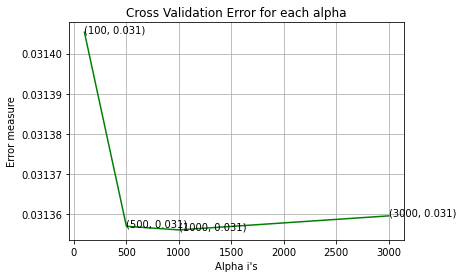

Done *************** Done


In [17]:
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

print("Done *************** Done")

In [18]:
X_test = getPickel("/scratch/sisodiya.bhoomendra/X_test.pkl")
y_test = getPickel("/scratch/sisodiya.bhoomendra/y_test.pkl")

In [19]:
x_cfl = xgb_models[best_alpha]
sig_clf = calibration_models[best_alpha]
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of best alpha =  1000 The train log loss is: 0.015649960952976397
For values of best alpha =  1000 The cross validation log loss is: 0.031356068428278865
For values of best alpha =  1000 The test log loss is: 0.05039140380844563


Number of misclassified points  1.1039558417663293
-------------------------------------------------- Confusion matrix --------------------------------------------------


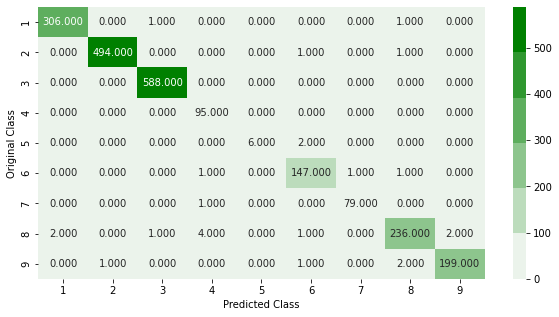

-------------------------------------------------- Precision matrix --------------------------------------------------


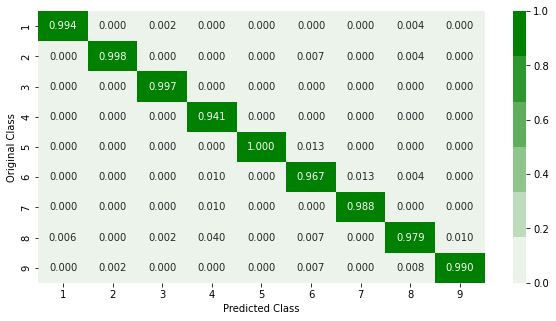

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


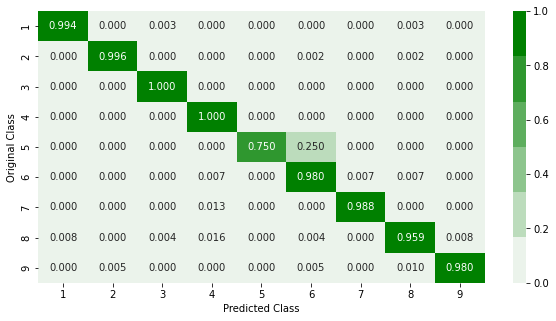

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
import seaborn as sns
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

In [3]:
# Finding the 2000 most frequent in byte file and in asm file finding the 800 most frequent across all the files
# Those will be used as features